<a href="https://colab.research.google.com/github/dudaholandah/NLP/blob/main/Projeto/Cuisine_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r '/content/drive/MyDrive/NLP-Project/cuisine-classification-ingredients' 'cuisine-classification-ingredients'

# Imports

In [ ]:
!pip install gensim --upgrade
!pip install keras
!pip install tensorflow
!pip install keras-tuner --upgrade
!pip install glove-python-binary

In [ ]:
#WORD2VEC
from gensim.models import Word2Vec
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download('punkt')
#GLOVE
from glove import Corpus, Glove
#Neural Network
import keras_tuner as kt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Conv1D,Embedding,GlobalMaxPooling1D,Activation,SimpleRNN,Dropout,Masking,LSTM
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD
from keras_tuner import HyperModel
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
#Data
import json
import os
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Data

## Download

In [ ]:
path = 'cuisine-classification-ingredients/train.json'

with open(path, 'r') as f:
  json_file = json.load(f)

In [ ]:
df_cuisine = pd.DataFrame(json_file, columns=['id', 'cuisine', 'ingredients'])

In [ ]:
df_cuisine = df_cuisine.drop(['id'], axis=1)

In [ ]:
df_cuisine = df_cuisine[:10000]

In [ ]:
df_cuisine.head(5)

,cuisine,ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,"[water, vegetable oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pe..."


## Pre-Processing

In [ ]:
def pre_processing(text):
  new = ""
  for word in text.split(','):
    word = re.sub(r'[^\w\s]', '', word.lower())
    word = re.sub(r'[0-9]+', '', word)
    word = re.sub(r'\boz\b', '', word)
    word = re.sub(r'\ba taste of\b', '', word)
    new = new + word.strip() + " "

  return new[:-1]

In [ ]:
df_cuisine['ingredients'] = [','.join(x).strip() for x in df_cuisine['ingredients']]

In [ ]:
df_cuisine['ingredients'] = [pre_processing(x) for x in df_cuisine['ingredients']]

In [ ]:
X = df_cuisine['ingredients']
y = df_cuisine['cuisine']

# dados de teste = 20% do treinamento
X_train_cuisine, X_test_cuisine, y_train_cuisine, y_test_cuisine = train_test_split(X, y, test_size=0.2)

# dados de validacao = 50% do teste
X_test_cuisine, X_valid_cuisine, y_test_cuisine, y_valid_cuisine = train_test_split(X, y, test_size=0.5)

In [ ]:
y_train_cuisine = pd.Categorical(y_train_cuisine)
y_train_int_cuisine = y_train_cuisine.codes

y_valid_cuisine = pd.Categorical(y_valid_cuisine)
y_valid_int_cuisine = y_valid_cuisine.codes

y_test_cuisine = pd.Categorical(y_test_cuisine)
target_names_cuisine = y_test_cuisine.categories
y_test_int_cuisine = y_test_cuisine.codes

y_train_cuisine = to_categorical(y_train_int_cuisine)
y_valid_cuisine = to_categorical(y_valid_int_cuisine)
y_test_cuisine = to_categorical(y_test_int_cuisine)

# Embeddings

In [ ]:
MAX_LENGTH = 50

## Word2Vec

In [ ]:
def create_embedding_w2v(tokenizer, model, vocab_size, embedding_dim):
  embedding_w2v = np.zeros((vocab_size, embedding_dim))
  for word, i in tokenizer.word_index.items():
    if word in model.wv:
      embedding_w2v[i] = model.wv.get_vector(word)
    else:
      embedding_w2v[i]=np.random.normal(0,np.sqrt(0.25), embedding_dim)
  return embedding_w2v

In [ ]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_cuisine)
vocab_size_cuisine = len(tokenizer.word_index) + 1

In [ ]:
# Train Data
encoded_w2v = tokenizer.texts_to_sequences(X_train_cuisine)
X_train_w2v_padded = pad_sequences(encoded_w2v, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Valid Data
encoded_w2v = tokenizer.texts_to_sequences(X_valid_cuisine)
X_valid_w2v_padded = pad_sequences(encoded_w2v, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Test Data
encoded_w2v = tokenizer.texts_to_sequences(X_test_cuisine)
X_test_w2v_padded = pad_sequences(encoded_w2v, maxlen=MAX_LENGTH, padding='post', truncating='post')

In [ ]:
# EMBEDDING LAYER

EMBEDDING_DIM_W2V = 100

sentences = [sentence.split() for sentence in X_train_cuisine]
model_word2vec = Word2Vec(sentences, vector_size=EMBEDDING_DIM_W2V, min_count=1, window=5, sg=1,workers=4)

embedding_w2v = create_embedding_w2v(tokenizer, model_word2vec, vocab_size_cuisine, EMBEDDING_DIM_W2V)

## GloVe

In [ ]:
def create_embedding_glove(glove, vocab_size, embedding_dim):
  embedding_glove = np.zeros((vocab_size, embedding_dim))
  for i, word in enumerate(glove.dictionary):
    embedding_glove[i+1] = glove.word_vectors[i]
  return embedding_glove

In [ ]:
def texts_to_sequences(df_text):
  encoded_glove = []
  for sentence in df_text:
    xs = []
    for word in sentence.split():
      if glove.dictionary.get(word) is not None:
        xs.append(glove.dictionary[word]+1)
      else:
        xs.append(0)
    encoded_glove.append(xs)
  return encoded_glove

In [ ]:
corpus = Corpus() 
 
sentences = [sentence.split() for sentence in X_train_cuisine]
corpus.fit(sentences, window=10)

In [ ]:
# EMBEDDING LAYER

EMBEDDING_DIM_GLV = 100

glove = Glove(no_components=EMBEDDING_DIM_GLV, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=30, no_threads=2)
glove.add_dictionary(corpus.dictionary)
embedding_glove = create_embedding_glove(glove, vocab_size_cuisine, EMBEDDING_DIM_GLV)

In [ ]:
# Train Data
encoded_glove = texts_to_sequences(X_train_cuisine)
X_train_glove_padded = pad_sequences(encoded_glove, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Valid Data
encoded_glove = texts_to_sequences(X_valid_cuisine)
X_valid_glove_padded = pad_sequences(encoded_glove, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Test Data
encoded_glove = texts_to_sequences(X_test_cuisine)
X_test_glove_padded = pad_sequences(encoded_glove, maxlen=MAX_LENGTH, padding='post', truncating='post')

# CNN

In [ ]:
class CNNHyperModel(HyperModel):
  def __init__(self, embedding_layer, output):
    self.embedding_layer = embedding_layer
    self.output = output

  def build(self, hp):
    model = Sequential()
    model.add(self.embedding_layer)
    model.add(Conv1D(filters=hp.Choice("conv", [64,128,256]), kernel_size=6, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(hp.Choice("dense1", [64,128]), activation='relu'))
    model.add(Dense(hp.Choice("dense2", [32,64]), activation='relu'))
    model.add(Dense(self.output, activation='softmax'))
    sgd = SGD(learning_rate=0.01)
    model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
    return model

### WORD2VEC

In [ ]:
embedding_layer = Embedding(input_dim=vocab_size_cuisine, output_dim=EMBEDDING_DIM_W2V, weights=[embedding_w2v], input_length=MAX_LENGTH, trainable=False)

In [ ]:
model_CNN = CNNHyperModel(embedding_layer, 20)

In [ ]:
tuner = kt.Hyperband(
    model_CNN,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

In [ ]:
tuner.search(X_train_w2v_padded,y_train_cuisine,validation_data=(X_valid_w2v_padded,y_valid_cuisine),epochs=50)

Trial 12 Complete [00h 00m 11s]
val_accuracy: 0.4968000054359436

Best val_accuracy So Far: 0.5440000295639038
Total elapsed time: 00h 03m 16s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model_cuisine = tuner.hypermodel.build(best_hps)

In [ ]:
model_cuisine.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           216000    
                                                                 
 conv1d_1 (Conv1D)           (None, 45, 256)           153856    
                                                                 
 dropout_1 (Dropout)         (None, 45, 256)           0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                      

In [ ]:
history_fine = model_cuisine.fit(X_train_w2v_padded,y_train_cuisine,validation_data=(X_valid_w2v_padded,y_valid_cuisine), epochs=100) 

Epoch 1/100
250/250 [==============================] - 10s 38ms/step - loss: 2.3105 - accuracy: 0.3613 - val_loss: 2.2088 - val_accuracy: 0.4678
Epoch 2/100
250/250 [==============================] - 9s 37ms/step - loss: 1.7605 - accuracy: 0.5008 - val_loss: 1.8772 - val_accuracy: 0.5326
Epoch 3/100
250/250 [==============================] - 9s 38ms/step - loss: 1.5537 - accuracy: 0.5426 - val_loss: 1.7758 - val_accuracy: 0.5600
Epoch 4/100
250/250 [==============================] - 9s 37ms/step - loss: 1.4446 - accuracy: 0.5644 - val_loss: 1.6567 - val_accuracy: 0.5886
Epoch 5/100
250/250 [==============================] - 9s 37ms/step - loss: 1.3710 - accuracy: 0.5845 - val_loss: 1.5632 - val_accuracy: 0.5930
Epoch 6/100
250/250 [==============================] - 10s 41ms/step - loss: 1.3097 - accuracy: 0.5971 - val_loss: 1.5623 - val_accuracy: 0.6076
Epoch 7/100
250/250 [==============================] - 9s 37ms/step - loss: 1.2652 - accuracy: 0.6093 - val_loss: 1.4765 - val_accurac

In [ ]:
target_names = pd.Categorical(df_cuisine['cuisine']).categories

In [ ]:
y_prob = model_cuisine.predict(X_test_w2v_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int_cuisine,y_pred, target_names=target_names))

              precision    recall  f1-score   support

   brazilian       0.78      0.84      0.81        51
     british       0.78      0.78      0.78        97
cajun_creole       0.92      0.91      0.91       215
     chinese       0.93      0.96      0.95       337
    filipino       0.95      0.81      0.87        90
      french       0.87      0.88      0.87       330
       greek       0.94      0.88      0.91       154
      indian       0.96      0.98      0.97       363
       irish       0.92      0.82      0.87        72
     italian       0.95      0.96      0.95      1008
    jamaican       0.86      0.89      0.88        75
    japanese       0.93      0.91      0.92       175
      korean       0.92      0.92      0.92       117
     mexican       0.98      0.97      0.97       785
    moroccan       0.94      0.95      0.94        92
     russian       0.87      0.79      0.83        61
 southern_us       0.92      0.91      0.92       578
     spanish       0.78    

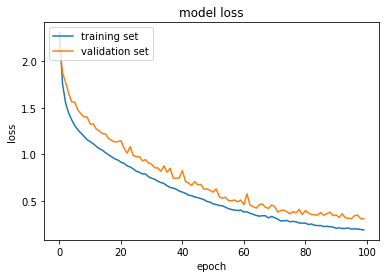

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')

if not os.path.exists("figs"): os.mkdir("figs")
plt.savefig('figs/loss_cnn_w2v.eps', format='eps')

plt.show()

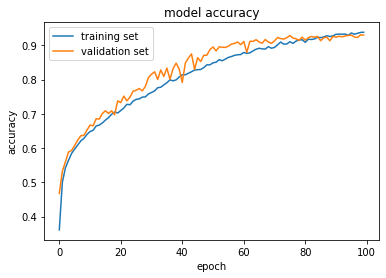

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.savefig('figs/acc_cnn_w2v.eps', format='eps')
plt.show()

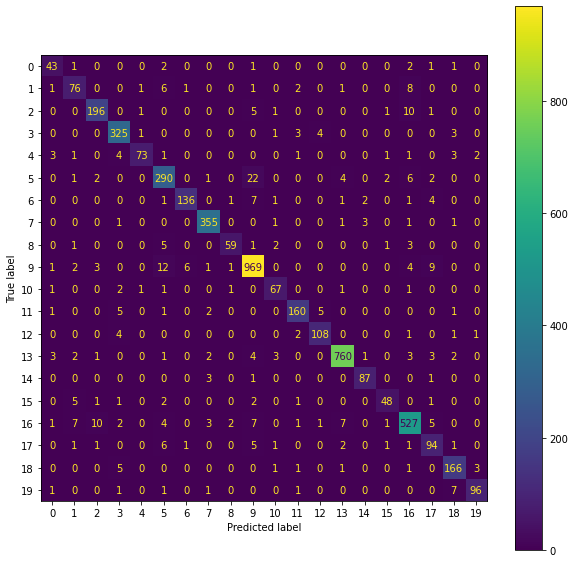

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_int_cuisine, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(10) 
fig.set_figheight(10)
plt.savefig('figs/matrixconf_cnn_w2v.eps', format='eps')
plt.show()

### GLOVE

In [ ]:
embedding_layer = Embedding(input_dim=vocab_size_cuisine, output_dim=EMBEDDING_DIM_GLV, weights=[embedding_glove], input_length=MAX_LENGTH, trainable=False)

In [ ]:
model_CNN = CNNHyperModel(embedding_layer, 20)

In [ ]:
tuner = kt.Hyperband(
    model_CNN,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

In [ ]:
tuner.search(X_train_glove_padded,y_train_cuisine,validation_data=(X_valid_glove_padded,y_valid_cuisine),epochs=50)

Trial 12 Complete [00h 00m 11s]
val_accuracy: 0.43140000104904175

Best val_accuracy So Far: 0.46619999408721924
Total elapsed time: 00h 03m 18s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model_cuisine = tuner.hypermodel.build(best_hps)

In [ ]:
model_cuisine.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           216000    
                                                                 
 conv1d_1 (Conv1D)           (None, 45, 256)           153856    
                                                                 
 dropout_1 (Dropout)         (None, 45, 256)           0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                      

In [ ]:
history_fine = model_cuisine.fit(X_train_glove_padded,y_train_cuisine,validation_data=(X_valid_glove_padded,y_valid_cuisine), epochs=100) 

Epoch 1/100
250/250 [==============================] - 10s 38ms/step - loss: 2.5139 - accuracy: 0.2771 - val_loss: 2.4839 - val_accuracy: 0.3602
Epoch 2/100
250/250 [==============================] - 10s 41ms/step - loss: 2.1233 - accuracy: 0.4105 - val_loss: 2.2126 - val_accuracy: 0.4376
Epoch 3/100
250/250 [==============================] - 9s 37ms/step - loss: 1.8563 - accuracy: 0.4675 - val_loss: 2.0308 - val_accuracy: 0.4946
Epoch 4/100
250/250 [==============================] - 9s 36ms/step - loss: 1.6928 - accuracy: 0.5011 - val_loss: 1.8862 - val_accuracy: 0.5092
Epoch 5/100
250/250 [==============================] - 9s 37ms/step - loss: 1.5948 - accuracy: 0.5171 - val_loss: 1.7764 - val_accuracy: 0.5320
Epoch 6/100
250/250 [==============================] - 10s 40ms/step - loss: 1.5256 - accuracy: 0.5399 - val_loss: 1.7252 - val_accuracy: 0.5568
Epoch 7/100
250/250 [==============================] - 11s 45ms/step - loss: 1.4742 - accuracy: 0.5537 - val_loss: 1.6980 - val_accur

In [ ]:
target_names = pd.Categorical(df_cuisine['cuisine']).categories

In [ ]:
y_prob = model_cuisine.predict(X_test_glove_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int_cuisine,y_pred, target_names=target_names))

              precision    recall  f1-score   support

   brazilian       0.76      0.80      0.78        51
     british       0.58      0.77      0.66        97
cajun_creole       0.87      0.91      0.89       215
     chinese       0.92      0.96      0.94       337
    filipino       0.83      0.82      0.83        90
      french       0.84      0.86      0.85       330
       greek       0.90      0.87      0.88       154
      indian       0.94      0.96      0.95       363
       irish       1.00      0.50      0.67        72
     italian       0.92      0.95      0.94      1008
    jamaican       0.89      0.84      0.86        75
    japanese       0.93      0.89      0.91       175
      korean       0.93      0.91      0.92       117
     mexican       0.97      0.94      0.96       785
    moroccan       0.91      0.93      0.92        92
     russian       0.82      0.59      0.69        61
 southern_us       0.91      0.88      0.89       578
     spanish       0.82    

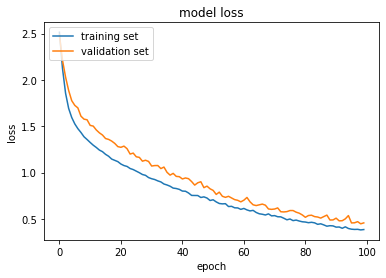

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.savefig('figs/loss_cnn_glv.eps', format='eps')
plt.show()

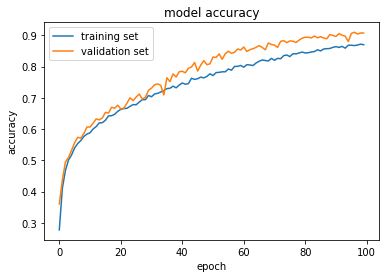

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.savefig('figs/acc_cnn_glv.eps', format='eps')
plt.show()

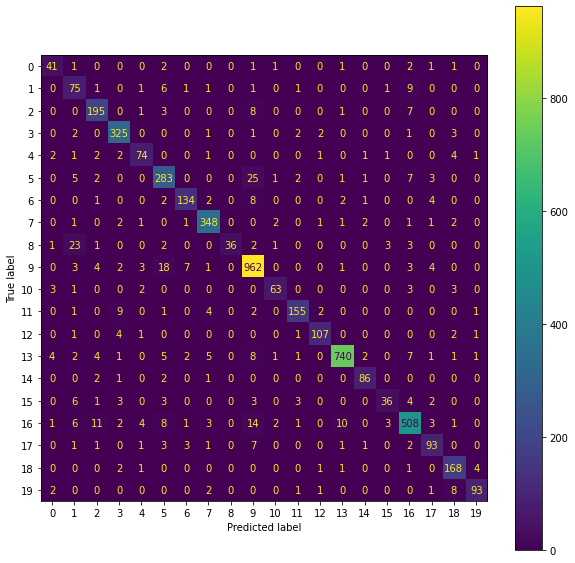

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_int_cuisine, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(10) 
fig.set_figheight(10)
plt.savefig('figs/matrixconf_cnn_glv.eps', format='eps')
plt.show()

# LSTM

In [ ]:
from keras_tuner import HyperModel

class LSTMHyperModel(HyperModel):
  def __init__(self, embedding_layer, output):
    self.embedding_layer = embedding_layer
    self.output = output

  def build(self, hp):
    model = Sequential()
    model.add(self.embedding_layer)
    model.add(Masking(mask_value=0.0))
    model.add(LSTM(hp.Choice("lstm", [64,128]), return_sequences=True))
    model.add(LSTM(hp.Choice("lstm", [32,64]), return_sequences=False)) #hp.Choice("lstm", [32,64]), return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(hp.Choice("dense1", [16,32]), activation='relu'))
    model.add(Dense(self.output, activation='softmax'))
    sgd = SGD(learning_rate=0.01)
    model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
    return model

### WORD2VEC

In [ ]:
embedding_layer = Embedding(input_dim=vocab_size_cuisine, output_dim=EMBEDDING_DIM_W2V, weights=[embedding_w2v], input_length=MAX_LENGTH, trainable=False)

In [ ]:
model_LSTM = LSTMHyperModel(embedding_layer, 20)

In [ ]:
tuner = kt.Hyperband(
    model_LSTM,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

In [ ]:
tuner.search(X_train_w2v_padded,y_train_cuisine,validation_data=(X_valid_w2v_padded,y_valid_cuisine),epochs=50)

Trial 4 Complete [00h 01m 30s]
val_accuracy: 0.18639999628067017

Best val_accuracy So Far: 0.3271999955177307
Total elapsed time: 00h 06m 23s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model_cuisine = tuner.hypermodel.build(best_hps)

In [ ]:
model_cuisine.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           216000    
                                                                 
 masking_1 (Masking)         (None, 50, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 128)           117248    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dense_3 (Dense)             (None, 20)               

In [ ]:
history_fine = model_cuisine.fit(X_train_w2v_padded,y_train_cuisine,validation_data=(X_valid_w2v_padded,y_valid_cuisine), epochs=100) 

Epoch 1/100
250/250 [==============================] - 51s 178ms/step - loss: 2.8526 - accuracy: 0.1670 - val_loss: 2.7273 - val_accuracy: 0.1872
Epoch 2/100
250/250 [==============================] - 42s 167ms/step - loss: 2.6335 - accuracy: 0.2035 - val_loss: 2.5638 - val_accuracy: 0.1950
Epoch 3/100
250/250 [==============================] - 44s 175ms/step - loss: 2.4690 - accuracy: 0.2803 - val_loss: 2.3608 - val_accuracy: 0.3438
Epoch 4/100
250/250 [==============================] - 44s 175ms/step - loss: 2.2551 - accuracy: 0.3654 - val_loss: 2.1327 - val_accuracy: 0.4080
Epoch 5/100
250/250 [==============================] - 42s 168ms/step - loss: 2.0674 - accuracy: 0.4356 - val_loss: 1.9694 - val_accuracy: 0.4684
Epoch 6/100
250/250 [==============================] - 42s 167ms/step - loss: 1.9176 - accuracy: 0.4821 - val_loss: 1.8160 - val_accuracy: 0.4914
Epoch 7/100
250/250 [==============================] - 46s 185ms/step - loss: 1.7966 - accuracy: 0.4955 - val_loss: 1.7302 -

In [ ]:
target_names = pd.Categorical(df_cuisine['cuisine']).categories

In [ ]:
y_prob = model_cuisine.predict(X_test_w2v_padded)
y_pred = np.argmax(y_prob,axis=1) 
print(classification_report(y_test_int_cuisine,y_pred, target_names=target_names, zero_division=1))

              precision    recall  f1-score   support

   brazilian       0.75      0.12      0.20        51
     british       0.19      0.12      0.15        97
cajun_creole       0.75      0.62      0.68       215
     chinese       0.69      0.82      0.75       337
    filipino       0.37      0.43      0.40        90
      french       0.42      0.53      0.47       330
       greek       0.64      0.65      0.65       154
      indian       0.80      0.89      0.84       363
       irish       0.35      0.15      0.21        72
     italian       0.78      0.86      0.82      1008
    jamaican       0.65      0.40      0.50        75
    japanese       0.51      0.38      0.43       175
      korean       0.59      0.48      0.53       117
     mexican       0.91      0.90      0.90       785
    moroccan       0.66      0.68      0.67        92
     russian       0.00      0.00      0.00        61
 southern_us       0.64      0.71      0.67       578
     spanish       0.57    

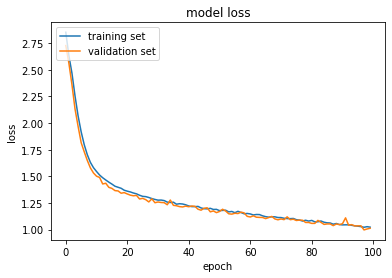

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.savefig('figs/loss_lstm_w2v.eps', format='eps')
plt.show()

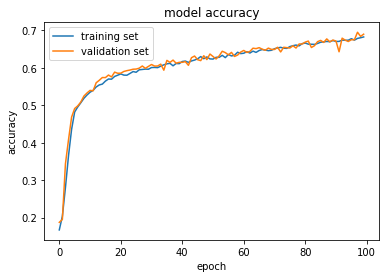

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.savefig('figs/acc_lstm_w2v.eps', format='eps')
plt.show()

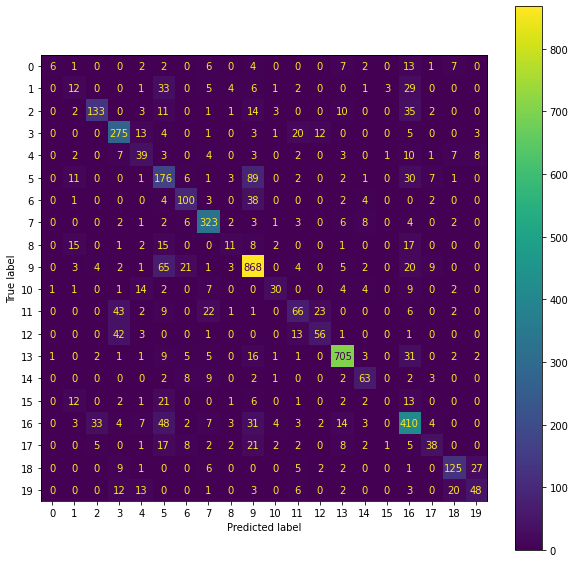

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_int_cuisine, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(10) 
fig.set_figheight(10)
plt.savefig('figs/matrixconf_lstm_w2v.eps', format='eps')
plt.show()

### GLOVE

In [ ]:
embedding_layer = Embedding(input_dim=vocab_size_cuisine, output_dim=EMBEDDING_DIM_GLV, weights=[embedding_glove], input_length=MAX_LENGTH, trainable=False)

In [ ]:
model_LSTM = LSTMHyperModel(embedding_layer, 20)

In [ ]:
tuner = kt.Hyperband(
    model_LSTM,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

In [ ]:
tuner.search(X_train_glove_padded,y_train_cuisine,validation_data=(X_valid_glove_padded,y_valid_cuisine),epochs=50)

Trial 4 Complete [00h 01m 35s]
val_accuracy: 0.18719999492168427

Best val_accuracy So Far: 0.19460000097751617
Total elapsed time: 00h 07m 40s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model_cuisine = tuner.hypermodel.build(best_hps)

In [ ]:
model_cuisine.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           216000    
                                                                 
 masking_1 (Masking)         (None, 50, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 128)           117248    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 20)               

In [ ]:
history_fine = model_cuisine.fit(X_train_glove_padded,y_train_cuisine,validation_data=(X_valid_glove_padded,y_valid_cuisine), epochs=100) 

Epoch 1/100
250/250 [==============================] - 58s 197ms/step - loss: 2.8268 - accuracy: 0.1839 - val_loss: 2.6817 - val_accuracy: 0.1872
Epoch 2/100
250/250 [==============================] - 42s 167ms/step - loss: 2.6393 - accuracy: 0.1998 - val_loss: 2.6118 - val_accuracy: 0.1872
Epoch 3/100
250/250 [==============================] - 41s 164ms/step - loss: 2.5834 - accuracy: 0.2132 - val_loss: 2.5524 - val_accuracy: 0.2168
Epoch 4/100
250/250 [==============================] - 45s 179ms/step - loss: 2.4912 - accuracy: 0.2578 - val_loss: 2.3971 - val_accuracy: 0.3298
Epoch 5/100
250/250 [==============================] - 41s 165ms/step - loss: 2.2949 - accuracy: 0.3610 - val_loss: 2.1698 - val_accuracy: 0.3876
Epoch 6/100
250/250 [==============================] - 41s 163ms/step - loss: 2.0946 - accuracy: 0.4074 - val_loss: 2.0021 - val_accuracy: 0.4268
Epoch 7/100
250/250 [==============================] - 42s 168ms/step - loss: 1.9714 - accuracy: 0.4356 - val_loss: 1.8917 -

In [ ]:
target_names = pd.Categorical(df_cuisine['cuisine']).categories

In [ ]:
y_prob = model_cuisine.predict(X_test_glove_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int_cuisine,y_pred, target_names=target_names, zero_division=1))

              precision    recall  f1-score   support

   brazilian       0.00      0.00      0.00        51
     british       0.50      0.01      0.02        97
cajun_creole       0.71      0.69      0.70       215
     chinese       0.75      0.66      0.70       337
    filipino       0.43      0.44      0.44        90
      french       0.35      0.44      0.39       330
       greek       0.75      0.42      0.54       154
      indian       0.75      0.88      0.81       363
       irish       0.36      0.06      0.10        72
     italian       0.69      0.85      0.76      1008
    jamaican       0.50      0.37      0.43        75
    japanese       0.45      0.41      0.43       175
      korean       0.53      0.47      0.50       117
     mexican       0.80      0.89      0.84       785
    moroccan       0.71      0.63      0.67        92
     russian       1.00      0.00      0.00        61
 southern_us       0.54      0.58      0.56       578
     spanish       0.45    

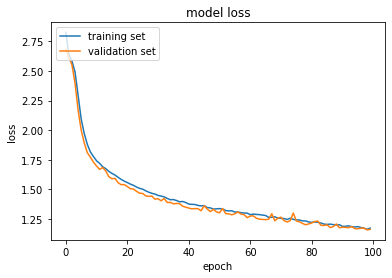

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.savefig('figs/loss_lstm_glv.eps', format='eps')
plt.show()

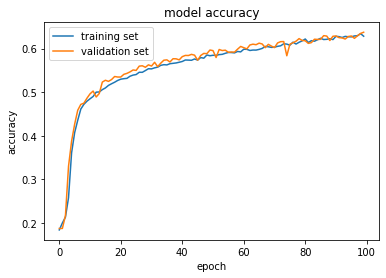

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.savefig('figs/acc_lstm_glv.eps', format='eps')
plt.show()

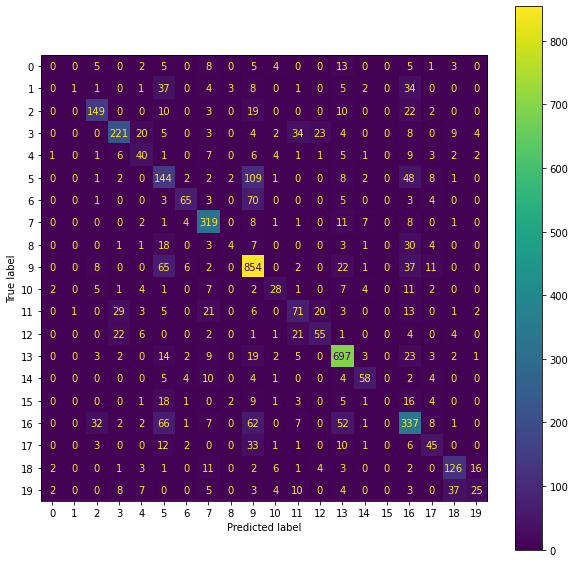

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_int_cuisine, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(10) 
fig.set_figheight(10)
plt.savefig('figs/matrixconf_lstm_glv.eps', format='eps')
plt.show()